# Modelo

## Instalación de paquetes y descarga dataset MS COCO

*NOTA: Estamos usando el dataset "MS COCO 2017 Validation set" para entrenar el modelo. Habría que usar el "Training set" de COCO como hacen en el paper, pero por ahora lo hacemos sobre éste porque es mucho más liviano (1gb contra 18gb). Éste de validación lo deberíamos usar como holdout a la hora de evaluar, más adelante.*

In [0]:
!wget -q http://images.cocodataset.org/zips/val2017.zip -O coco.zip
#!wget http://images.cocodataset.org/zips/train2014.zip -O coco.zip
!unzip -q coco.zip

In [0]:
!pip install opencv-python keras

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from glob import glob
import numpy as np
import os
import shutil
import random
import cv2
import gc
import matplotlib.pyplot as plt
from itertools import zip_longest

%matplotlib inline

## División de train / validation

Dividimos el dataset de imágenes en dos conjuntos, uno de entrenamiento y otro de validación.

In [0]:
X = glob(os.path.join('val2017', '*.jpg'))

In [0]:
len(X), X[0]

(5000, 'val2017/000000315001.jpg')

In [0]:
def train_test_split(X, test_size=0.2):
    n_test = round(len(X) * test_size)
    random.shuffle(X)
    test_samples, train_samples = X[:n_test], X[n_test:]
    return train_samples, test_samples

In [0]:
X_train, X_val = train_test_split(X, test_size=0.2)
len(X_train), len(X_val)

(4000, 1000)

In [0]:
# Armamos un dataset aún más chiquito, para debuggear el modelo en caso de que
# no funcione bien...
Xs_train, Xs_val = train_test_split(X_val, test_size=0.2)
len(Xs_train), len(Xs_val)

(800, 200)

In [0]:
dataset = dict(train=X_train, val=X_val, small_train=Xs_train, small_val=Xs_val)

for set_name in ['train', 'val', 'small_train', 'small_val']:
    base_dir = os.path.join('data', set_name)
    os.makedirs(base_dir, exist_ok=True)
    for src in dataset[set_name]:
        dst = os.path.join(base_dir, os.path.basename(src))
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)

## Generación de datos y *augmentation*

In [101]:
WIDTH, HEIGHT = 320, 240
RHO = 32
PATCH_SIZE = 128
NUM_SAMPLES_PER_IMAGE = 100

BATCH_SIZE = 64

TRAIN_DIR = os.path.join('data', 'train')
VAL_DIR = os.path.join('data', 'val')

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    classes=[''])

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    classes=[''])

Found 4000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


In [0]:
def random_patch_positions():
    """Calculate random position for patch P"""
    px = random.randint(RHO, WIDTH - PATCH_SIZE - RHO)
    py = random.randint(RHO, HEIGHT - PATCH_SIZE - RHO)
    return px, py  

  
def random_delta():
    """Calculate random delta for patch corner distortion"""
    return np.random.randint(-RHO, RHO, size=2)
  
  
def extract_from_patch(img, patch):
    """Extract patch from image"""
    a, _, c, _ = patch
    return img[a[1]:c[1], a[0]:c[0]]
  
  
def build_random_patch():
    px, py = random_patch_positions()
    return [(px, py),
            (px + PATCH_SIZE, py),
            (px + PATCH_SIZE, py + PATCH_SIZE),
            (px, py + PATCH_SIZE)]
  
  
def distort_patch(patch):
    return [p + random_delta() for p in patch]
  
  
def preproc_image(img):
    # Rescale
    img = img / 255.0
    # Sample-wise centering
    img -= np.mean(img, axis=0, keepdims=True)
    # Sample-wise std normalization
    img /= (np.std(img, axis=0, keepdims=True) + 1e-7)    
    return img

  
def warp_image(img, patch, new_patch):
    # Get homography matrix
    H = cv2.getPerspectiveTransform(
        np.float32(patch),
        np.float32(new_patch))
    
    # Transform image with H
    return cv2.warpPerspective(img, H,
        (img.shape[1], img.shape[0]))  

  
def process_image(img, debug=False):
    # Resize and convert to grayscale
    resized_img = cv2.resize(img, (WIDTH, HEIGHT))
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
 
    # Build patch, and perturb corners
    patch = build_random_patch()
    distorted_patch = distort_patch(patch)

    warped_img = warp_image(gray_img, patch, distorted_patch)
    
    # Extract patches
    a_img = extract_from_patch(gray_img, patch)
    b_img = extract_from_patch(warped_img, patch)
    
    # Preprocess and stack patch images together
    x = np.dstack([preproc_image(a_img), preproc_image(b_img)])

    # Return final image as "instance", and distorted_patch as "label"
    if not debug:
        return x, np.ravel(distorted_patch)
    else:
        # On debug mode, return also original patch and warped img for plotting
        return (x, np.ravel(distorted_patch),
                (patch, distorted_patch), (gray_img, warped_img))

In [0]:
def plot_processed_image(img_path):
    img = plt.imread(img_path)
    inputs, labels, patches, imgs = process_image(img, debug=True)
    
    for i in range(2):
        plt.subplot(2, 2, i+1)
        plt.grid(False)    
        temp_img = cv2.cvtColor(imgs[i], cv2.COLOR_GRAY2RGB)
        cv2.polylines(temp_img, np.int32([patches[i]]), 1, (255, 0, 0), thickness=2)    
        plt.imshow(temp_img, cmap='gray')

    for i in range(2):
        patch_img = inputs[:, :, i]
        
        print('[{}] shape={}'.format(i, patch_img.shape))        
        print('[{}] mean={}, std={}'.format(
            i, np.mean(patch_img), np.std(patch_img)))
      
        plt.subplot(2, 2, i+3)
        plt.grid(False)
        plt.imshow(patch_img, cmap='gray')
        #plt.text(0.5,0.5, str((2, 2, i)), ha=’center’, fontsize = 10)
        plt.tight_layout()

[0] shape=(128, 128)
[0] mean=1.0477729794899915e-15, std=0.99999946810468
[1] shape=(128, 128)
[1] mean=1.6930901125533637e-15, std=0.9999993855158869


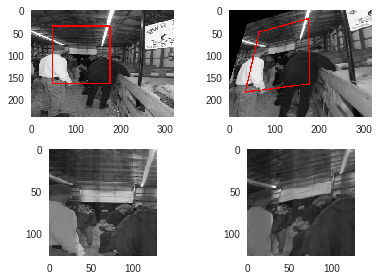

In [122]:
plot_processed_image(Xs_train[0])

[0] shape=(128, 128)
[0] mean=-1.27675647831893e-15, std=0.9999996406154456
[1] shape=(128, 128)
[1] mean=-9.992007221626409e-16, std=0.9999995919835089


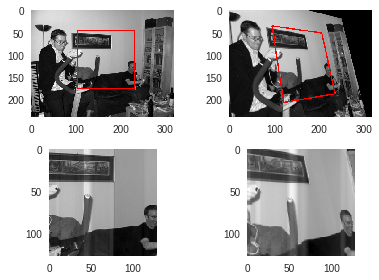

In [123]:
plot_processed_image(Xs_train[10])

In [0]:
def build_data_generator_single(generator):
    for img_batch, _ in generator:  
        for img in img_batch:
            for i in range(NUM_SAMPLES_PER_IMAGE):
                inputs, labels = process_image(img)
                yield inputs, labels      


def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

               
def build_data_generator(generator):
    iterable = build_data_generator_single(generator)
    for batch in grouper(BATCH_SIZE, iterable):
        batch = [b for b in batch if b]
        xs = np.array([x for x, y in batch])
        ys = np.array([y for x, y in batch])
        yield xs, ys

In [0]:
gen = build_data_generator(train_generator)

In [0]:
inputs, labels = next(gen)

In [127]:
len(inputs), len(labels)

(64, 64)

In [128]:
inputs[0].shape, labels[0].shape

((128, 128, 2), (8,))

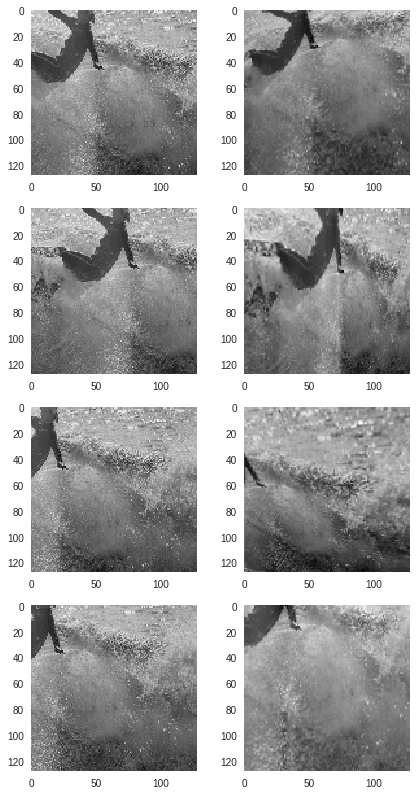

In [147]:
plt.figure(figsize=(7,7*2))

for i in range(4):
    img_a = inputs[i][:, :, 0]
    plt.subplot(4, 2, (i*2)+1)
    plt.grid(False)
    plt.imshow(img_a, cmap='gray')
    #plt.tight_layout()
    
    img_b = inputs[i][:, :, 1]
    plt.subplot(4, 2, (i*2)+2)
    plt.grid(False)
    plt.imshow(img_b, cmap='gray')
    #plt.tight_layout()    

In [0]:
train_datagen = build_data_generator(train_generator)
val_datagen = build_data_generator(val_generator)

## Definición del Modelo

In [0]:
def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.maximum(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True), K.epsilon()))

def mean_avg_corner_error(y_true, y_pred):
    size = K.shape(y_true)[0]
    c_true = K.reshape(y_true, (4 * size, 2))
    c_pred = K.reshape(y_pred, (4 * size, 2))
    return K.mean(euclidean_distance_loss(c_true, c_pred))
  
  
def euclidean_l2(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))

def mace(y_true, y_pred):
    return K.mean(RHO * K.sqrt(K.sum(K.square(K.reshape(y_pred, (-1,4,2)) - K.reshape(y_true, (-1,4,2))),\
        axis=-1, keepdims=True)),axis=1)  
  
def homography_regression_model():
    input_shape = (128, 128, 2)
    input_img = Input(shape=input_shape)
     
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv1', activation='relu')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv2', activation='relu')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(x)
    
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv3', activation='relu')(x)
    x = BatchNormalization()(x)    
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv4', activation='relu')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(x)
   
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv5', activation='relu')(x)
    x = BatchNormalization()(x)    
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv6', activation='relu')(x)
    x = BatchNormalization()(x)    
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3')(x)
    
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv7', activation='relu')(x)
    x = BatchNormalization()(x)    
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv8', activation='relu')(x)
    x = BatchNormalization()(x)    
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)    
    x = Dense(1024, name='fc1', activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(8, name='fc2', activation=None)(x)
    
    model = Model(inputs=input_img, outputs=[out])
    
    model.compile(optimizer=SGD(lr=0.005, momentum=0.9),
                  loss=euclidean_l2,
                  metrics=['mse', mace])

    return model

In [0]:
model = homography_regression_model()

In [151]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 128, 128, 2)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 64)      1216      
_________________________________________________________________
batch_normalization_57 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_58 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 64)        36928     
__________

In [152]:
total_iterations = 90000

steps_per_epoch = len(X_train) // BATCH_SIZE
epochs = total_iterations // steps_per_epoch

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min', verbose=1)

history = model.fit_generator(train_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_datagen,
    validation_steps=len(X_val) // BATCH_SIZE,
    callbacks = [reduce_lr])

Epoch 1/1451
62/62 [==============================] - 31s 499ms/step - loss: 195.7348 - mean_squared_error: 6887.2430 - mace: 2972.5090 - val_loss: 140.9275 - val_mean_squared_error: 2993.4864 - val_mace: 2149.9395
Epoch 2/1451
62/62 [==============================] - 26s 415ms/step - loss: 121.7973 - mean_squared_error: 2198.3249 - mace: 1850.5314 - val_loss: 151.2790 - val_mean_squared_error: 3229.2779 - val_mace: 2306.3847
Epoch 3/1451
62/62 [==============================] - 26s 414ms/step - loss: 119.2977 - mean_squared_error: 2104.0817 - mace: 1806.5425 - val_loss: 107.9846 - val_mean_squared_error: 1726.5042 - val_mace: 1658.9426
Epoch 4/1451
62/62 [==============================] - 26s 415ms/step - loss: 114.1060 - mean_squared_error: 1903.7628 - mace: 1733.6157 - val_loss: 121.6137 - val_mean_squared_error: 2096.5347 - val_mace: 1864.2668
Epoch 5/1451
62/62 [==============================] - 26s 414ms/step - loss: 151.7316 - mean_squared_error: 3503.0862 - mace: 2294.7497 - va

KeyboardInterrupt: ignored

In [0]:
model.save('model.h5')

In [0]:
!du -sh model.h5

392M	model.h5


In [0]:
!gsutil -m cp model.h5 gs://dym-temp-public/HomographyNet_weights.h5

Copying file://model.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/391.4 MiB.                                    


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gcloud config set project golden-system-178513

Updated property [core/project].


In [0]:
# Correr esto para liberar memoria
K.clear_session()
del model
gc.collect()

1036